# Multi Label Classification: Auto Tagging

Importing required Libraries

In [1]:
import re

import joblib
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import (
    jaccard_score,
    precision_score,
    recall_score,
    f1_score,
    hamming_loss, accuracy_score, )
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

Loading Dataset

In [2]:
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")
dataset

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Climate risk and response: Physical hazards an...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,New Accenture Research Finds Leaders and Emplo...,Organization,Talent|Culture & transformational change
2,"Me, my life, my wallet - The widespread and im...","Growth, Marketing & Sales",Customer experience
3,The next normal arrives: Trends that will defi...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,Our 2021 technology predictions for businesses...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...
...,...,...,...
19995,How to reshape aerospace and defence supply ch...,Aerospace & Defense|Operations|Risk & Resilience,Aerospace & Defense- Other|Manufacturing & sup...
19996,Why current challenges make a more sustainable...,Banking,Retail banking|Consumer Credit
19997,What companies should consider when making cli...,Strategy & Corporate Finance|Sustainability,CFO-Finance-Capital Markets|Sustainability inv...
19998,Post-Brexit trade: Navigating the disruption -...,Operations,Operations- Other


Dataset Information

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics

In [4]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing


In [5]:
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"], dataset["PRACTICE/AREA"], dataset["SL/SUB-AREA"], test_size=0.1, random_state=41
)

In [6]:
testingDataset = pd.concat([X_test_1, y_test_1], axis=1)
testingDataset.reset_index(drop=True, inplace=True)
testingDataset.head()

,SUMMARY,PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...


In [7]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [8]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    # Remove punctuation and numbers
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    # Tokenize
    tokens = word_tokenize(document)
    # Remove duplicate words
    tokens = list(set(tokens))
    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [9]:
X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [10]:
X_train_1.head()

3065     worrying already desperate almost attempt rece...
2672     begin system encouraging allow waysfrom busine...
14299    show belief cbi club retailer item earlier bal...
469      company already online vulnerable company infe...
61       massmarket captivate road ev automaker emobili...
Name: SUMMARY, dtype: object

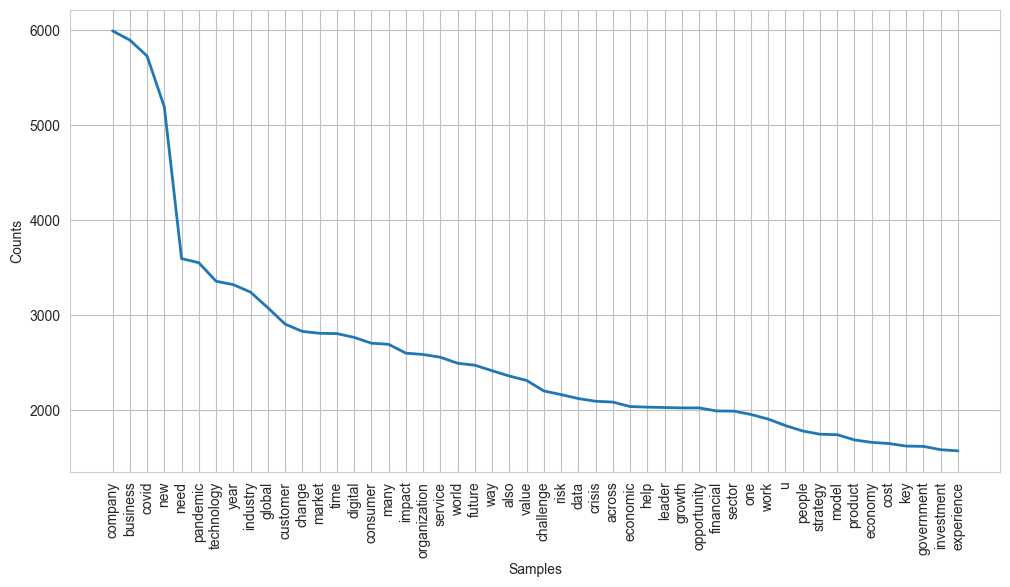

Total Words Count:  840500


In [11]:
corpus = " ".join(X_train_1)

tokens = nltk.word_tokenize(corpus)
fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print("Total Words Count: ", len(tokens))

In [12]:
y_train_1 = y_train_1.str.split("|")
y_test_1 = y_test_1.str.split("|")

y_train_1.head()

3065     [Strategy & Corporate Finance, Risk & Resilien...
2672     [McKinsey Technology, Telecom, Media & Technol...
14299                   [Public And Social Sector, Retail]
469      [Strategy & Corporate Finance, Organization, G...
61                 [Automotive, Growth, Marketing & Sales]
Name: PRACTICE/AREA, dtype: object

In [13]:
mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
y_train_1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (DnA),...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
joblib.dump(mlb, 'mlb.joblib')

['mlb.joblib']

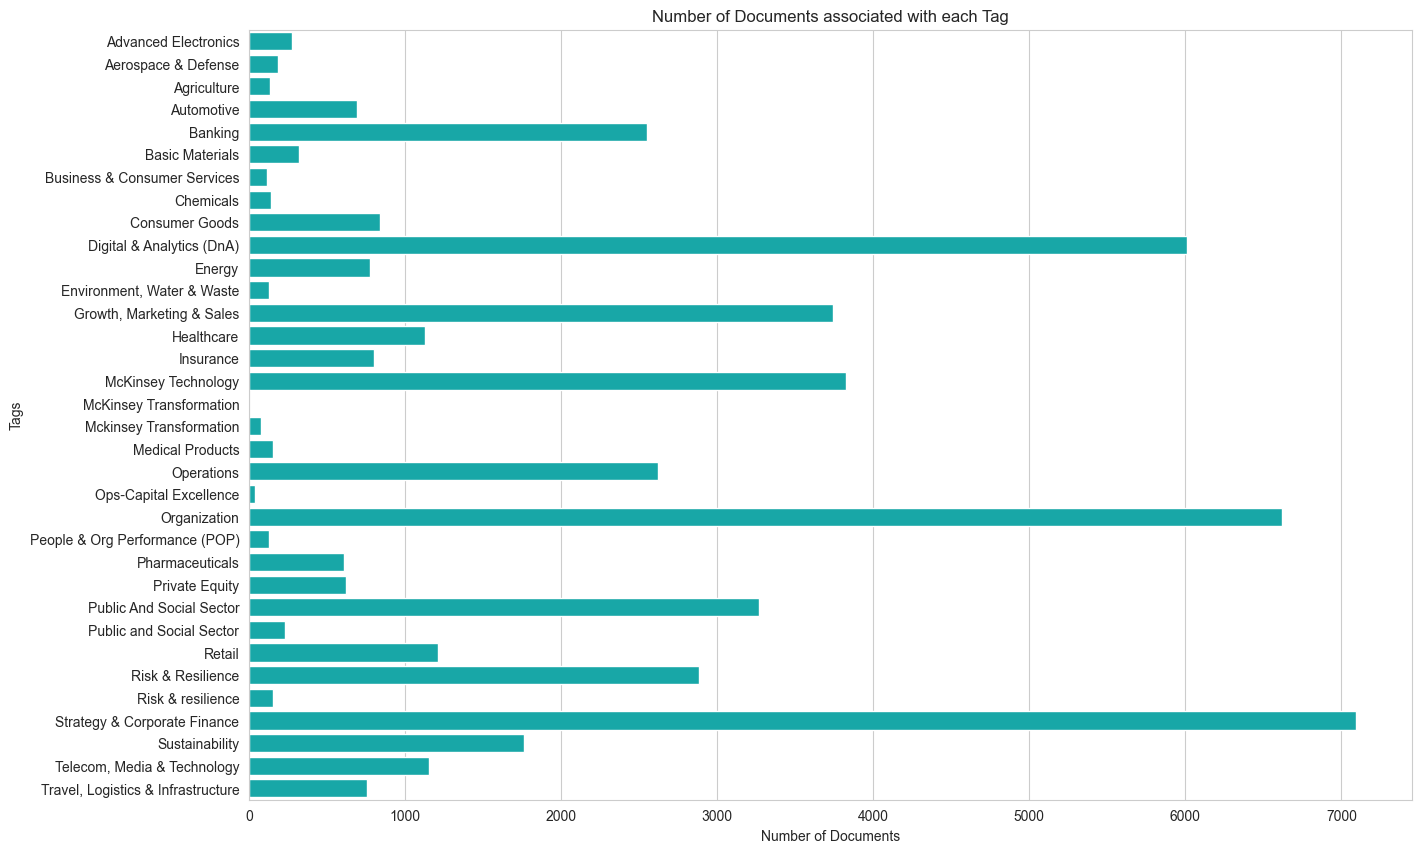

In [15]:
tag_counts = y_train_1.sum(numeric_only=True) + y_test_1.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

Text Vectorization


In [16]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, 'tfidfmodel.joblib')
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((18000, 506918), (2000, 506918))

### Model Training


Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

DTC_1 = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0))
dtc1 = DTC_1.fit(X_train_tfidf_1, y_train_1)

Random Forest Classifier



In [18]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

Stochastic Gradient Descent Classifier


In [19]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

Logistic Regression


In [20]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

Support Vector Classifier


In [21]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)

XGBoost Classifier


In [22]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

Voting Classsifier

In [23]:
log_clf = LogisticRegression(solver="liblinear")
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma="auto", probability=True)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("xgb", xgb_clf)],
    voting="soft",
)

ovr_voting_1 = OneVsRestClassifier(voting_clf)
ovr_voting_1.fit(X_train_tfidf_1, y_train_1)  # Make sure to fit it with your train data

OneVsRestClassifier(estimator=VotingClassifier(estimators=[('lr',
                                                            LogisticRegression(solver='liblinear')),
                                                           ('rf',
                                                            RandomForestClassifier()),
                                                           ('svc',
                                                            SVC(gamma='auto',
                                                                probability=True)),
                                                           ('xgb',
                                                            XGBClassifier(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          device=None,
                                                                          early_stopping_rounds=None...
                                                                          importance_type=None,
                                                                          interaction_constraints=None,
                                                                          learning_rate=None,
                                                                          max_bin=None,
                                                                          max_cat_threshold=None,
                                                                          max_cat_to_onehot=None,
                                                                          max_delta_step=None,
                                                                          max_depth=None,
                                                                          max_leaves=None,
                                                                          min_child_weight=None,
                                                                          missing=nan,
                                                                          monotone_constraints=None,
                                                                          multi_strategy=None,
                                                                          n_estimators=100,
                                                                          n_jobs=None,
                                                                          num_parallel_tree=None,
                                                                          random_state=None, ...))],
                                               voting='soft'))

In [24]:
def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracies = []
    for true_labels, pred_labels in zip(y_true, y_pred):
        accuracies.append(accuracy_score(true_labels, pred_labels))
    return np.mean(accuracies)

In [ ]:
eva_matrix = []

In [ ]:
def Evaluate_Matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracies = []
    precision = []
    recall = []
    f1 = []
    hamming = []
    jaccard = []
    for true_labels, pred_labels in zip(y_true, y_pred):
        accuracies.append(accuracy_score(true_labels, pred_labels))
        precision.append(precision_score(true_labels, pred_labels, average="samples", zero_division=0))
        recall.append(recall_score(true_labels, pred_labels, average="samples", zero_division=0))
        f1.append(f1_score(true_labels, pred_labels, average="samples", zero_division=0))
        hamming.append(hamming_loss(true_labels, pred_labels))
        jaccard.append(jaccard_score(true_labels, pred_labels, average='samples'))
    eva_matrix.append(np.mean(accuracies))
    eva_matrix.append(np.mean(precision))
    eva_matrix.append(np.mean(recall))
    eva_matrix.append(np.mean(f1))
    eva_matrix.append(np.mean(hamming))
    eva_matrix.append(np.mean(jaccard))
    return eva_matrix

In [25]:
models = [
    ("RandomForest", rfc1),
    ("DecisonTree", dtc1),
    ("SGD", sgd1),
    ("LogisticRegression", lr1),
    ("LinearSVC", svc1),
    ("XGBoost", xgb1),
    ('VotingClassifier', ovr_voting_1)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    accuracy = calculate_accuracy(y_test_1, predictions)
    precision = precision_score(
        y_test_1, predictions, average="samples", zero_division=0
    )
    recall = recall_score(y_test_1, predictions, average="samples", zero_division=0)
    f1 = f1_score(y_test_1, predictions, average="samples", zero_division=0)
    hamming_loss_value = hamming_loss(y_test_1, predictions)

    jaccard = jaccard_score(y_test_1, predictions, average='samples')

    model_comparison[model_name] = {
        "Accuracy": accuracy,
        "Recall/Sensy": recall,
        "Jaccard Score": jaccard,
        "Precision": precision,
        "F1 Score": f1,
        "Hamming Loss": hamming_loss_value,
    }

    joblib.dump(model, model_name + ".joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

,Accuracy,Recall/Sensy,Jaccard Score,Precision,F1 Score,Hamming Loss
RandomForest,0.941956,0.326110,0.312047,0.544167,0.380855,0.058044
DecisonTree,0.917176,0.588148,0.361252,0.474165,0.480857,0.082824
SGD,0.948265,0.468125,0.432604,0.690125,0.522167,0.051735
LogisticRegression,0.943588,0.393725,0.365292,0.606033,0.445688,0.056412
LinearSVC,0.949926,0.567611,0.489228,0.716050,0.590911,0.050074
XGBoost,0.946162,0.600953,0.485979,0.673217,0.591703,0.053838
VotingClassifier,0.949485,0.507004,0.457519,0.712208,0.552247,0.050515


In [ ]:
models = [
    ("RandomForest", rfc1),
    ("DecisonTree", dtc1),
    ("SGD", sgd1),
    ("LogisticRegression", lr1),
    ("LinearSVC", svc1),
    ("XGBoost", xgb1),
    ('VotingClassifier', ovr_voting_1)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    matrix = Evaluate_Matrix(y_test_1, predictions)
    model_comparison[model_name] = {
        "Accuracy": matrix[0],
        "Recall/Sensy": matrix[2],
        "Jaccard Score": matrix[5],
        "Precision": matrix[1],
        "F1 Score": matrix[3],
        "Hamming Loss": matrix[4],
    }
model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

#### Classification

In [27]:
text = [
    "pandemic spending result costello improve since return build access restricting way protection ability platform people role accelerated productivity back increased investment area digital recovery significant life make flexibility renew society le sure intervene reach supporting also everyday building review create virtual job movement new remotely world sustainable need infrastructure needed stay government sustainability essentially work may theyre certain challenge education play context onset seen lockdown government everything uk ireland directly term show done required future better economy say right trend globally healthcare help talking looking invest importance benefit employment step"
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = dtc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Organization', 'Public And Social Sector', 'Sustainability')]

In [28]:
GEN_PRACTICE_AREA = []

for value in testingDataset['SUMMARY']:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc1.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_PRACTICE/AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[('Public And Social Sector',)]
[('Sustainability',)]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Retail')]
[('Healthcare',)]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[('Operations', 'Strategy & Corporate Finance')]
[('Private Equity',)]
[('Banking',)]
[('Risk & Resilience', 'Strategy & Corporate Finance')]
[('Digital & Analytics (DnA)', 'Insurance', 'McKinsey Technology', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Consumer Goods', 'Digital & Analytics (DnA)', 'Growth, Marketing & Sales')]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[('Public And Social Sector',)]
[('Telecom, Media & Technology',)]
[('Strategy & Corporate Finance',)]
[('Banking', 'Risk & Resilience', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Insurance', 'Risk & Resilience')]
[('Growth, Marketing & Sales', 'Retail', 'Telecom, Media & Technology')]
[('Digital & Analytics (DnA)', 'Growth, Marketing & Sales')]
[('Growth, Marketing & Sales', 'Retail')]
[('Growth, Mar

In [29]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
# newDataset2.to_excel("generated_tags.xlsx", index=False)
# x = pd.read_excel('generated_tags.xlsx')
# x.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[(Public And Social Sector,)]"
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[(Sustainability,)]"
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[(Consumer Goods, Growth, Marketing & Sales, R..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[(Healthcare,)]"
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[(Digital & Analytics (DnA), McKinsey Technolo..."


### 2nd Level Prediction

In [30]:
y_test_2.reset_index(drop=True, inplace=True)
testingDataset = pd.concat([testingDataset, y_test_2], axis=1)
testingDataset.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA,SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[(Public And Social Sector,)]",Public infrastructure & cities|Capital excelle...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[(Sustainability,)]",Sustainability strategy & portfolio|Decarboniz...
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[(Consumer Goods, Growth, Marketing & Sales, R...",Consumer Goods- Other|Marketing strategy- bra...
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[(Healthcare,)]",Healthcare providers|M&A - S&CF|Manufacturing ...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[(Digital & Analytics (DnA), McKinsey Technolo...",Data transformation|PSSP- Other|Software|Digit...


In [31]:
y_train_2 = y_train_2.str.split("|")
y_test_2 = y_test_2.str.split("|")

y_train_2.head()

3065     [Corporate & Portfolio Strategy, Crisis Prepar...
2672     [McKinsey Technology- Other, Telecommunication...
14299                [Economic development, Retail- Other]
469      [Corporate & Portfolio Strategy, Talent, Sales...
61       [Future mobility, Customer experience, Automot...
Name: SL/SUB-AREA, dtype: object

In [32]:
mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
y_train_2.head()

,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,Agricultural produce trading & processing,Agriculture input distribution & service,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
joblib.dump(mlb2, 'mlb2.joblib')

['mlb2.joblib']

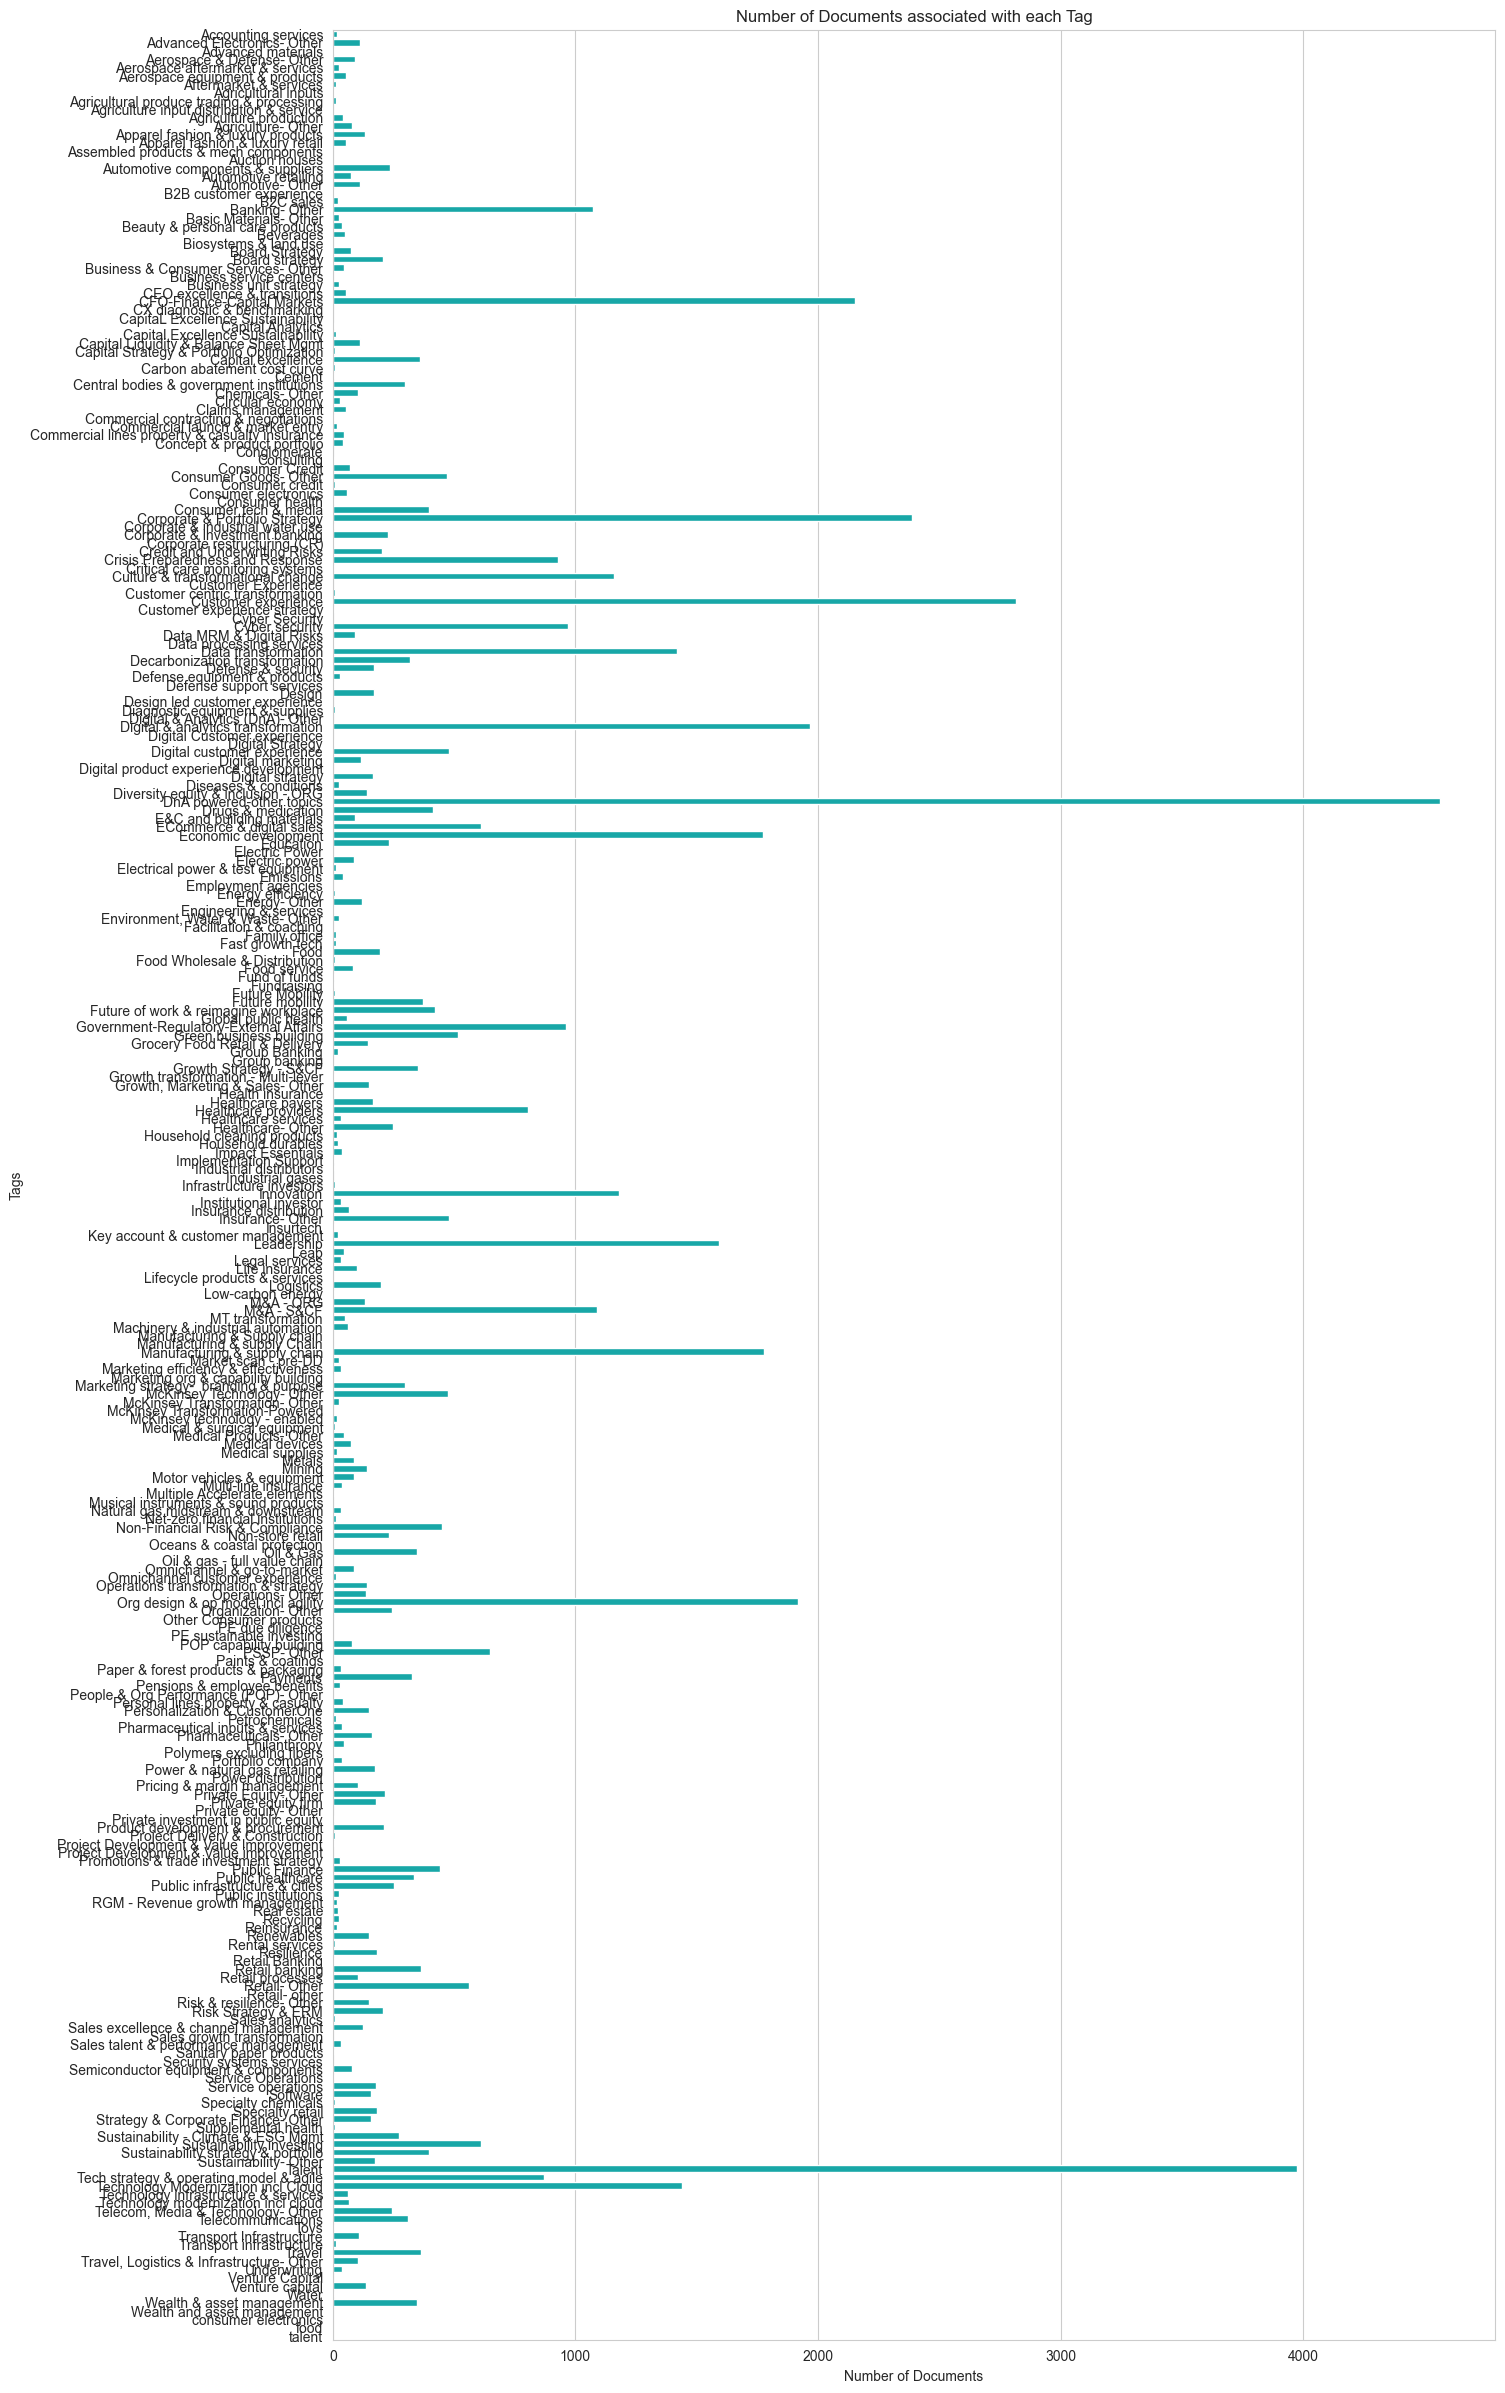

In [34]:
tag_counts = y_train_2.sum(numeric_only=True) + y_test_2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 30))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

In [35]:
DTC_2 = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', random_state=0))
dtc2 = DTC_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr2 = LR_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
log_clf_2 = LogisticRegression(solver="liblinear")
rnd_clf_2 = RandomForestClassifier(n_estimators=100)
xgb_clf_2 = XGBClassifier(n_estimators=100)
svm_clf_2 = SVC(gamma="auto", probability=True)

voting_clf2 = VotingClassifier(
    estimators=[("lr", log_clf_2), ("rf", rnd_clf_2), ("svc", svm_clf_2), ("xgb", xgb_clf_2)],
    voting="soft",
)

ovr_voting_2 = OneVsRestClassifier(voting_clf2)
ovr_voting_2.fit(X_train_tfidf_1, y_train_2)  # Make sure to fit it with your train data

In [ ]:
models = [
    ("RandomForest", rfc2),
    ("DecisionTree", dtc2),
    ("SGD", sgd2),
    ("LogisticRegression", lr2),
    ("LinearSVC", svc2),
    ("XGBoost", xgb2),
    ('VotingClassifier', ovr_voting_2)
]
model_comparison = {}
for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    accuracy = calculate_accuracy(y_test_2, predictions)
    precision = precision_score(
        y_test_2, predictions, average="samples", zero_division=0
    )
    recall = recall_score(y_test_2, predictions, average="samples", zero_division=0)
    f1 = f1_score(y_test_2, predictions, average="samples", zero_division=0)
    hamming_loss_value = hamming_loss(y_test_2, predictions)

    jaccard = jaccard_score(y_test_2, predictions, average='samples')

    model_comparison[model_name] = {
        "Accuracy": accuracy,
        "Recall/Sensy": recall,
        "Jaccard Score": jaccard,
        "Precision": precision,
        "F1 Score": f1,
        "Hamming Loss": hamming_loss_value,
    }

    joblib.dump(model, model_name + "2.joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

In [ ]:
GEN_PRACTICE_AREA = []

for value in testingDataset['SUMMARY']:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = dtc2.predict(text_tfidf)
    predicted_labels = mlb2.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_SL/SUB-AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

In [ ]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
testingDataset.to_excel("generated_tags.xlsx", index=False)
x = pd.read_excel('generated_tags.xlsx')
x.head()